In [19]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from scipy import sparse
from sklearn.decomposition import TruncatedSVD

In [20]:
df=pd.read_csv(r"..\data\processed\gutendex-cleaned-dataset_v3.csv")

In [21]:
tfidf_matrix = sparse.load_npz(r"../models/tfidf_matrix.npz")
print(tfidf_matrix.shape)

feature_names = np.load(r"../models/tfidf_feature_names.npy", allow_pickle=True)
print(len(feature_names))

(9149, 11742)
11742


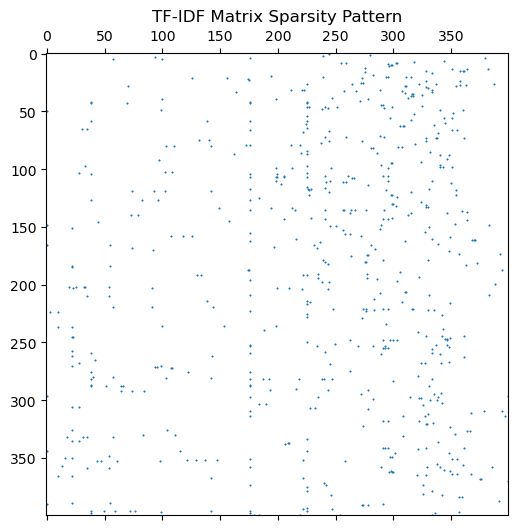

In [22]:
tfidf_sparse = sparse.csr_matrix(tfidf_matrix)

plt.figure(figsize=(6,6))
plt.spy(tfidf_sparse[:400,:400], markersize=0.5)
plt.title("TF-IDF Matrix Sparsity Pattern")
plt.show()

In [23]:
total_elements = tfidf_sparse.shape[0] * tfidf_sparse.shape[1]
non_zero = tfidf_sparse.nnz
sparsity = 1 - (non_zero / total_elements)

print("Total elements:", total_elements)
print("Non-zero elements:", non_zero)
print("Sparsity:", sparsity)


Total elements: 107427558
Non-zero elements: 736798
Sparsity: 0.9931414432784557


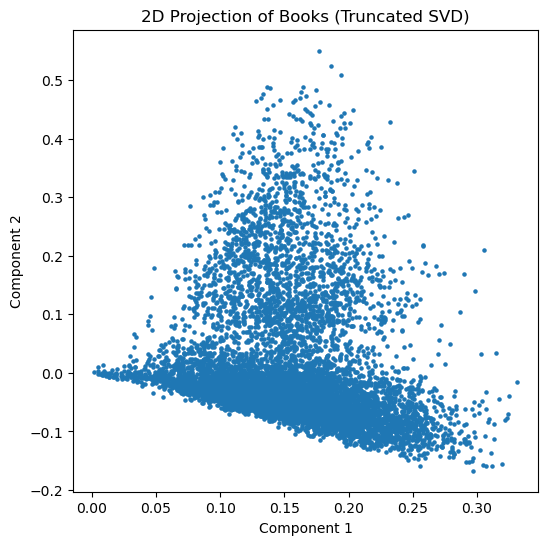

In [24]:
svd = TruncatedSVD(n_components=2, random_state=42)
reduced = svd.fit_transform(tfidf_sparse)

plt.figure(figsize=(6,6))
plt.scatter(reduced[:, 0], reduced[:, 1], s=5)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("2D Projection of Books (Truncated SVD)")
plt.show()


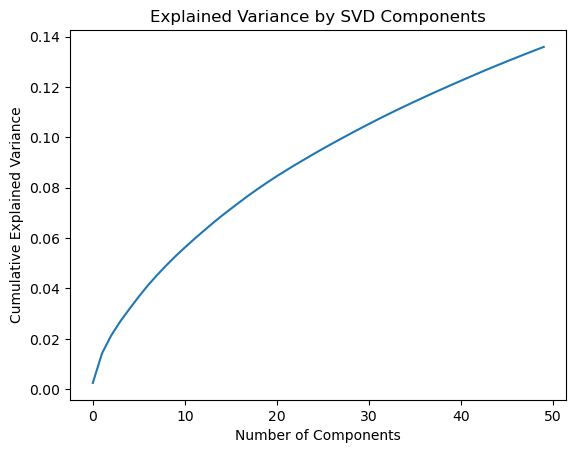

In [25]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np

svd_full = TruncatedSVD(n_components=50, random_state=42)
svd_full.fit(tfidf_sparse)

plt.figure()
plt.plot(np.cumsum(svd_full.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by SVD Components")
plt.show()


In [26]:
terms = feature_names

for i, comp in enumerate(svd.components_):
    top_indices = np.argsort(comp)[-15:]
    print(f"\nTop words for Component {i+1}:")
    print([terms[j] for j in top_indices])


Top words for Component 1:
['opening', 'work', 'english', 'stories', 'various', 'book', 'century', 'american', 'volume', 'early', 'literature', 'life', 'historical', 'fiction', 'history']

Top words for Component 2:
['tales', 'science', 'fantasy', 'published', 'love', 'adventure', 'literature', 'story', 'young', 'short', 'novels', 'novel', 'juvenile', 'stories', 'fiction']


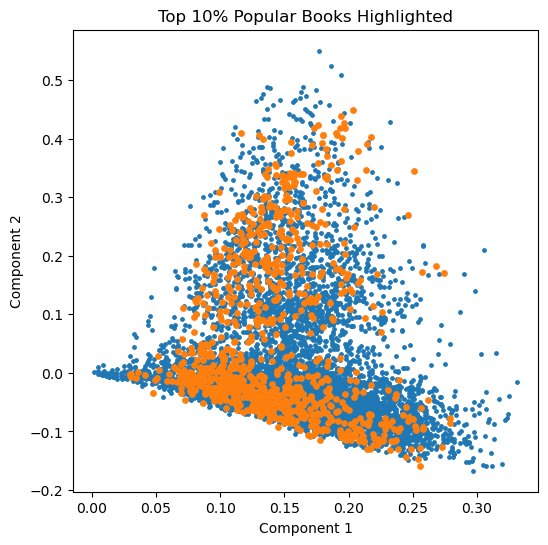

In [27]:
threshold = np.percentile(df['download_count'], 90)
high_pop = df['download_count'] >= threshold

plt.figure(figsize=(6,6))
plt.scatter(reduced[~high_pop, 0], reduced[~high_pop, 1], s=6)
plt.scatter(reduced[high_pop, 0], reduced[high_pop, 1], s=15)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Top 10% Popular Books Highlighted")
plt.show()


In [28]:
threshold = np.percentile(df['download_count'], 90)
high_pop = df['download_count'] >= threshold

print("Std Comp1 (High Pop):", reduced[high_pop, 0].std())
print("Std Comp2 (High Pop):", reduced[high_pop, 1].std())

print("Std Comp1 (All):", reduced[:, 0].std())
print("Std Comp2 (All):", reduced[:, 1].std())


Std Comp1 (High Pop): 0.04500278858219839
Std Comp2 (High Pop): 0.13652304409736235
Std Comp1 (All): 0.04932718068973757
Std Comp2 (All): 0.10704643669296049


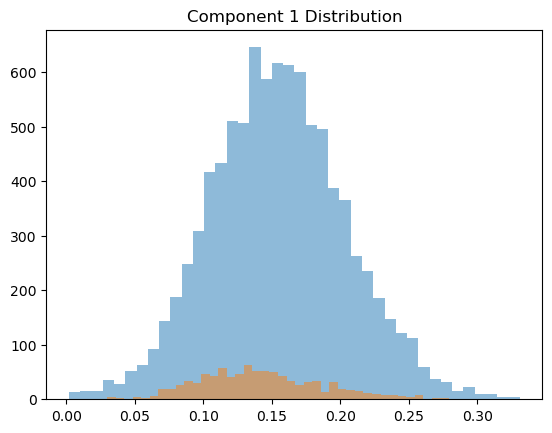

In [29]:
plt.hist(reduced[:, 0], bins=40, alpha=0.5)
plt.hist(reduced[high_pop, 0], bins=40, alpha=0.5)
plt.title("Component 1 Distribution")
plt.show()


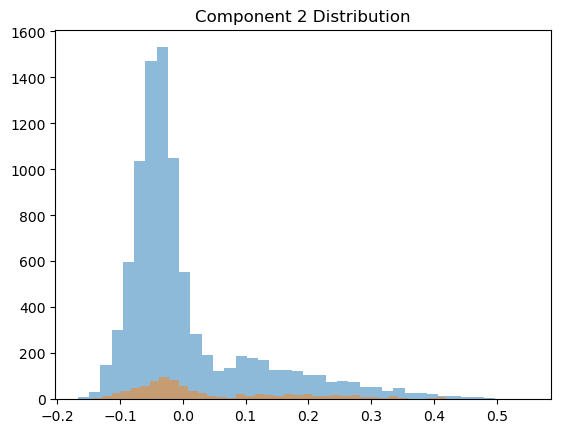

In [30]:
plt.hist(reduced[:, 1], bins=40, alpha=0.5)
plt.hist(reduced[high_pop, 1], bins=40, alpha=0.5)
plt.title("Component 2 Distribution")
plt.show()


In [31]:
top_pos = np.argsort(reduced[:,1])[-10:]
top_neg = np.argsort(reduced[:,1])[:10]

print("High Component 2 Books:")
print(df.iloc[top_pos][['title']])

print("Low Component 2 Books:")
print(df.iloc[top_neg][['title']])


High Component 2 Books:
                                             title
1419                      The Marvelous Land of Oz
1801  Cinderella : $b or, The little glass slipper
1844                            A daughter of Heth
2862                               "Moo-oo-oo-oo!"
3540                                 Tik-Tok of Oz
4504                      A Girl of the Limberlost
6172        The wondrous sickle, and other stories
3949                      Young man with a trumpet
1776                                 Night and Day
1787                                     Jane Eyre
Low Component 2 Books:
                                                  title
4151                             Early European History
870   Encyclopaedia Britannica, 11th Edition, "Anjar...
7974  The American Encyclopedia of History, Biograph...
7788  The Great Events by Famous Historians, Volume ...
4219  Narrative and Critical History of America, Vol...
6968   The Great Events by Famous Historians, Volume 11


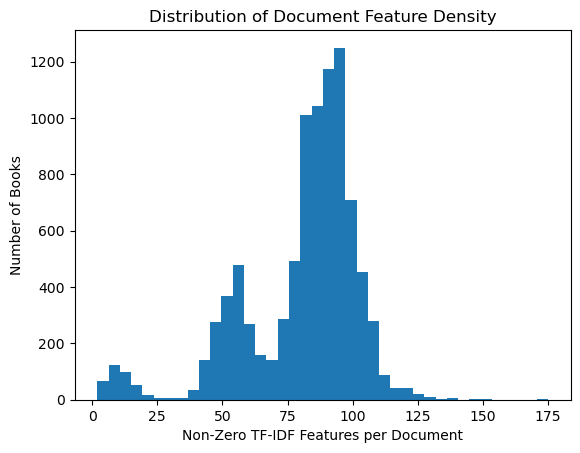

In [32]:
doc_nonzero = tfidf_sparse.getnnz(axis=1)

plt.figure()
plt.hist(doc_nonzero, bins=40)
plt.xlabel("Non-Zero TF-IDF Features per Document")
plt.ylabel("Number of Books")
plt.title("Distribution of Document Feature Density")
plt.show()


In [33]:
mean_tfidf = tfidf_sparse.mean(axis=0).A1
top_indices = np.argsort(mean_tfidf)[-20:]

for i in reversed(top_indices):
    print(feature_names[i])


history
fiction
historical
life
literature
early
century
american
volume
book
stories
work
various
english
written
opening
poetry
19th
narrative
collection


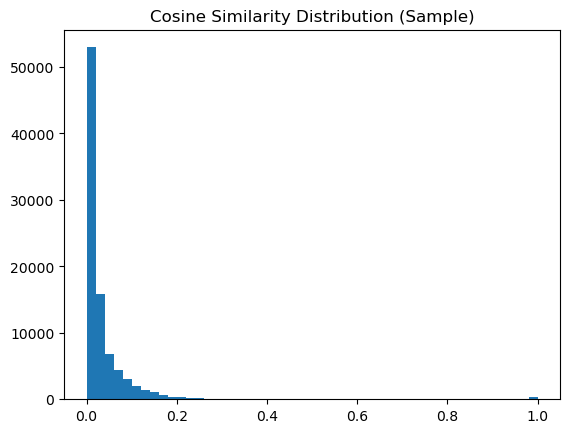

In [34]:
from sklearn.metrics.pairwise import cosine_similarity

sample_sim = cosine_similarity(tfidf_sparse[:300])
plt.figure()
plt.hist(sample_sim.flatten(), bins=50)
plt.title("Cosine Similarity Distribution (Sample)")
plt.show()


In [35]:
from scipy.stats import pearsonr

corr, pval = pearsonr(reduced[:,1], df['download_count'])
print(corr, pval)


0.17556922141304307 3.0672897017998e-64
